In [26]:
from mpl_toolkits import mplot3d # 三维画图
import numpy as np
import sys
from d2l import torch as d2l
import torch
import time
from torch import nn, optim
from IPython import display
from matplotlib import pyplot as plt
import math

In [2]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# 优化与深度学习

## 局部最小值

Text(0, 0.5, 'f(x)')

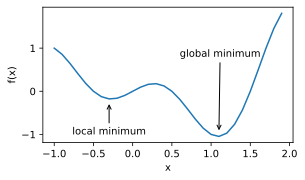

In [3]:
def f(x):
    return x * np.cos(np.pi*x)

set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                 arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)')

## 鞍点

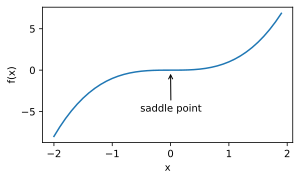

In [4]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)');

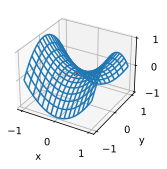

In [5]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1,  0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');


# 梯度下降和随机梯度下降

## 一维梯度下降

In [6]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

epoch 10, x: 0.06046617599999997


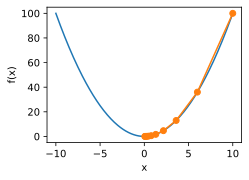

In [7]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    d2l.set_figsize()
    d2l.plt.plot(f_line, [x * x for x in f_line])
    d2l.plt.plot(res, [x * x for x in res], '-o')
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('f(x)')

show_trace(res)

## 学习率

epoch 10, x: 3.4867844009999995


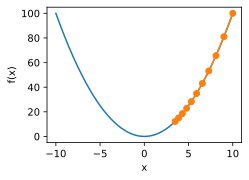

In [8]:
#下面展示使用学习率η=0.05
#时自变量xx的迭代轨迹。可见，同样迭代10次后，当学习率过小时
#最终xx的值依然与最优解存在较大偏差。
show_trace(gd(0.05))

epoch 10, x: 61.917364224000096


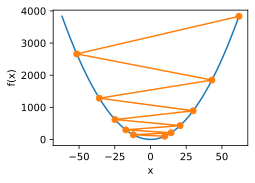

In [9]:
show_trace(gd(1.1))

## 多维梯度下降

In [10]:
def train_2d(trainer):
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' %(i+1, x1, x2))
    return results

def show_trace_2d(f, results):
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1 -0.057646, x2 -0.000073


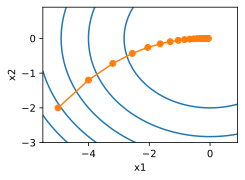

In [11]:
eta = 0.1
def f_2d(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta *2 *x1, x2-eta*4*x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

## 随机梯度下降

epoch 20, x1 0.036197, x2 0.125666


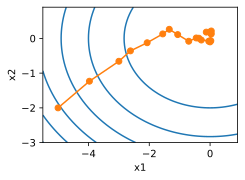

In [12]:
def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)),
            x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

# 小批量随机梯度下降

## 读取数据

In [13]:
def get_data_ch7():
    data = np.genfromtxt('./data/airfoil_self_noise.dat', delimiter='\t')
    data = (data-data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, : -1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_data_ch7()
features.shape

torch.Size([1500, 5])

## 从零开始实现

In [14]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

def linreg(X, w, b):
    #定义模型，矩阵乘法
    return torch.mm(X, w) + b 

def squared_loss(y_hat, y):
    #定义损失函数， 返回的损失向量
    return (y_hat-y.view(y_hat.size()))**2 / 2

In [15]:
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
             batch_size=10, num_epochs=2):
    net, loss = linreg, squared_loss
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0,0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)
    
    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()
    
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels),batch_size, shuffle=True)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fn([w, b], states, hyperparams)
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')
    

loss: 0.244304, 0.009974 sec per epoch


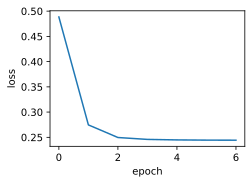

In [16]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

loss: 0.243577, 0.290911 sec per epoch


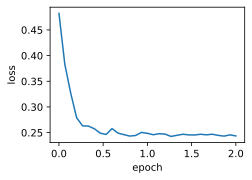

In [17]:
train_sgd(0.005, 1)

loss: 0.242551, 0.037903 sec per epoch


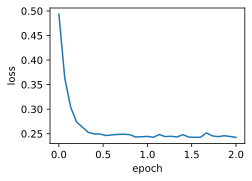

In [18]:
train_sgd(0.05, 10)

## 简洁实现

In [19]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')


loss: 0.251496, 0.040888 sec per epoch


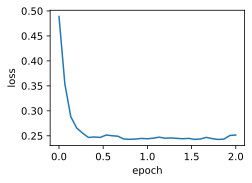

In [20]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)

# 动量法

epoch 20, x1: -0.943467, x2: -0.000073


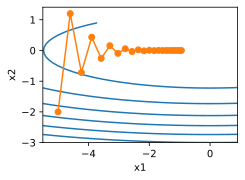

In [21]:
eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1- eta * 0.2 * x1, x2-eta*4*x2,0,0)
show_trace_2d(f_2d, d2l.train_2d(gd_2d))

epoch 20, x1: -0.387814, x2: -1673.365109


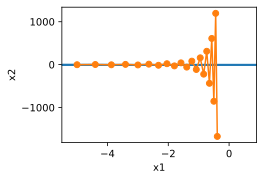

In [22]:
#试着将学习率调得稍大一点，
#此时自变量在竖直方向不断越过最优解并逐渐发散
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

## 动量法

epoch 20, x1: -0.062843, x2: 0.001202


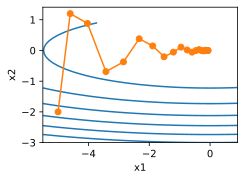

In [23]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2
eta, gamma = 0.4, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

epoch 20, x1: 0.007188, x2: 0.002553


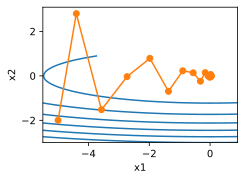

In [24]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

# AdaGrad

epoch 20, x1 -2.382563, x2 -0.158591


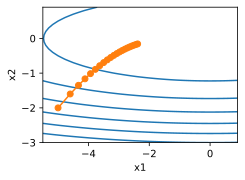

In [27]:
def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4*x2, 1e-6
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta/math.sqrt(s1+eps)*g1
    x2 -= eta/math.sqrt(s2+eps)*g2
    return x1,x2,s1,s2

def f_2d(x1,x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
eta=0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))

epoch 20, x1 -0.002295, x2 -0.000000


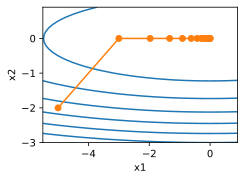

In [28]:
#下面将学习率增大到2。可以看到自变量更为迅速地逼近了最优解。
eta=2
show_trace_2d(f_2d, train_2d(adagrad_2d))

## 从零开始实现

In [29]:
features, labels = get_data_ch7()
def init_adagrad_states():
    s_w = torch.zeros((features.shape[1],1),dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data/ torch.sqrt(s+eps)

loss: 0.245859, 0.042858 sec per epoch


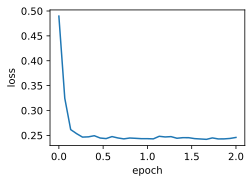

In [30]:
train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

## 简洁实现

loss: 0.242089, 0.046902 sec per epoch


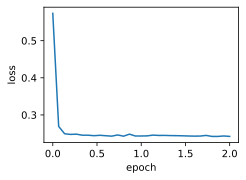

In [31]:
train_pytorch_ch7(torch.optim.Adagrad, {'lr':0.1}, features, labels)

# RMSProp算法

epoch 20, x1 -0.010599, x2 0.000000


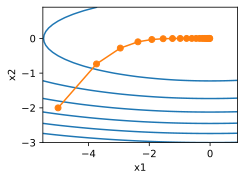

In [32]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

## 从零开始实现

In [34]:
features, labels = get_data_ch7()

def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1 - gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)


loss: 0.241839, 0.045877 sec per epoch


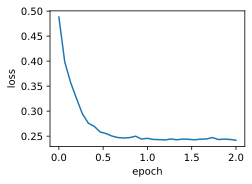

In [36]:
train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9},
              features, labels)


## 简洁实现


loss: 0.243038, 0.048897 sec per epoch


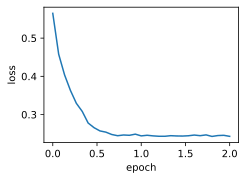

In [37]:
train_pytorch_ch7(torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9},
                    features, labels)

# AdaDelta
除了RMSProp算法以外，另一个常用优化算法AdaDelta算法也针对AdaGrad算法在迭代后期可能较难找到有用解的问题做了改进。有意思的是，AdaDelta算法没有学习率这一超参数。

## 从零开始实现

In [38]:
features, labels = get_data_ch7()

def init_adadelta_states():
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    delta_w, delta_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * (p.grad.data**2)
        g =  p.grad.data * torch.sqrt((delta + eps) / (s + eps))
        p.data -= g
        delta[:] = rho * delta + (1 - rho) * g * g

loss: 0.244449, 0.054852 sec per epoch


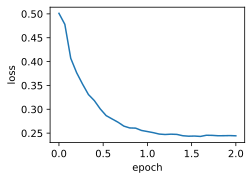

In [39]:
train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

## 简洁实现

loss: 0.264255, 0.051859 sec per epoch


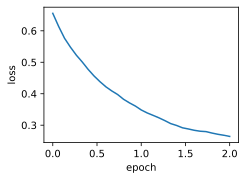

In [40]:
train_pytorch_ch7(torch.optim.Adadelta, {'rho': 0.9}, features, labels)

# Adam算法
Adam算法在RMSProp算法基础上对小批量随机梯度也做了指数加权移动平均。下面我们来介绍这个算法。

所以Adam算法可以看做是RMSProp算法与动量法的结合。

## 从零开始实现

In [41]:
features, labels = get_data_ch7()

def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * p.grad.data**2
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

loss: 0.248142, 0.056848 sec per epoch


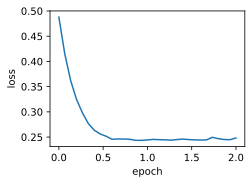

In [42]:
train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

## 简洁实现

loss: 0.243344, 0.052859 sec per epoch


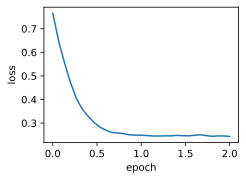

In [43]:
train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)